0.9125714285714286
1.17


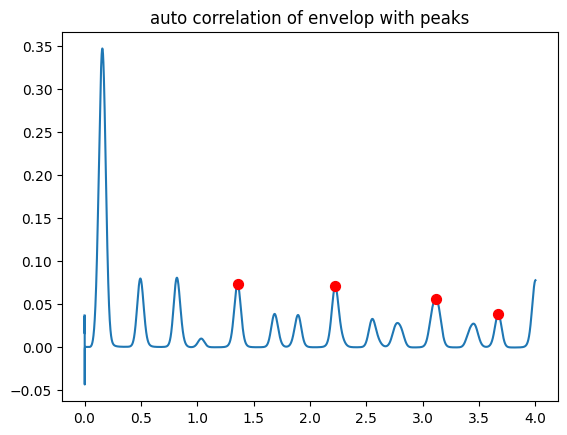

Passed criteria 1


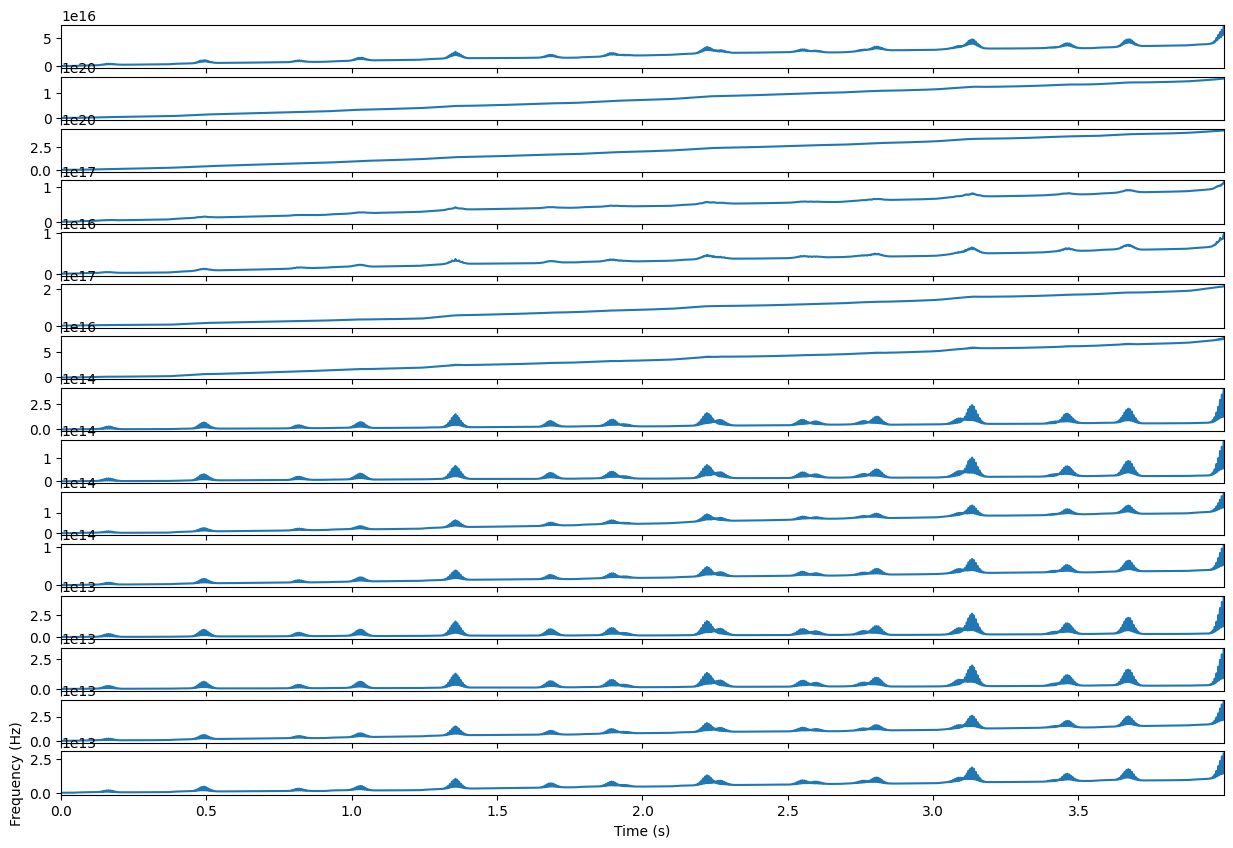

[3.552549696151903e-05, 0.0002909767896562709, 0.009312344171344892]
Passed criteria 2
Passed criteria 3


Passed criteria 1


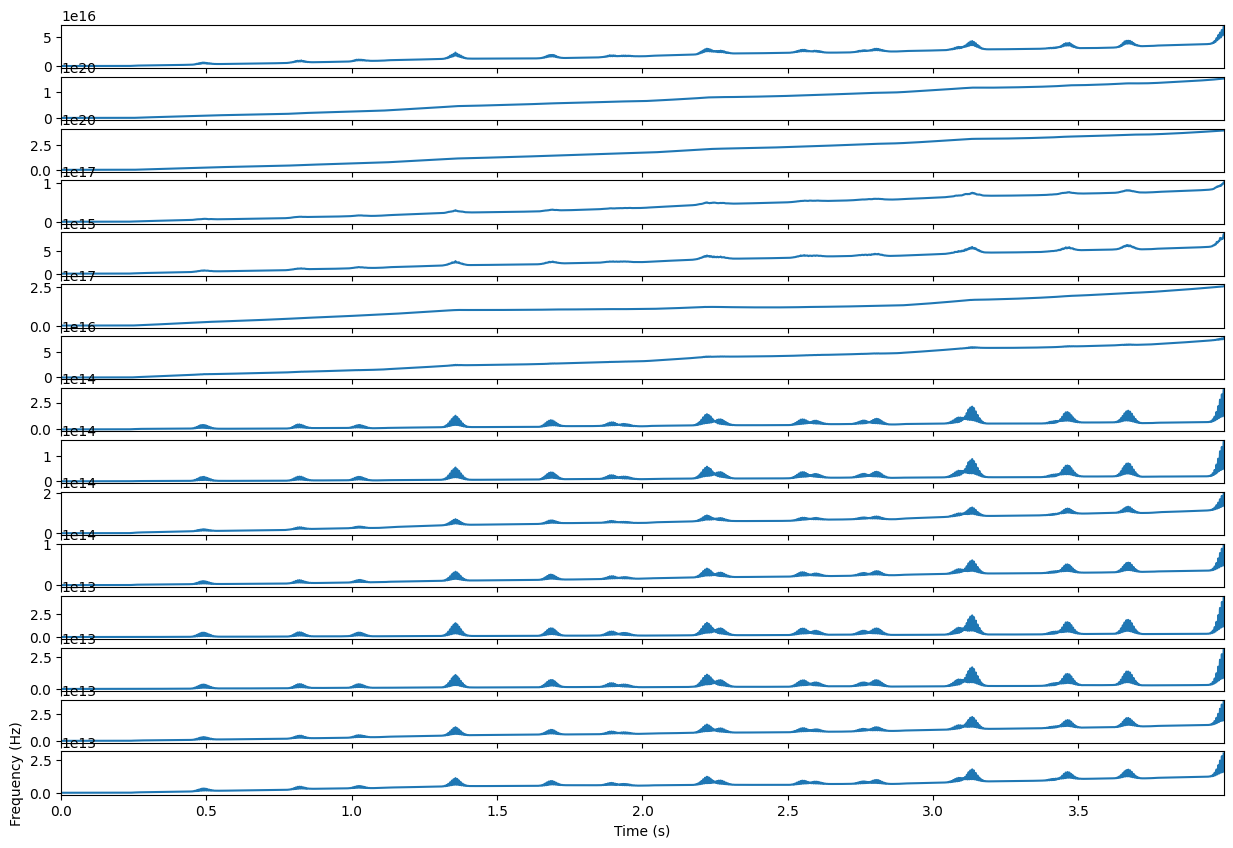

[2.1621903279314958e-05, 0.0010706818366652022, 0.008640464929870455]
Passed criteria 2
Passed criteria 3


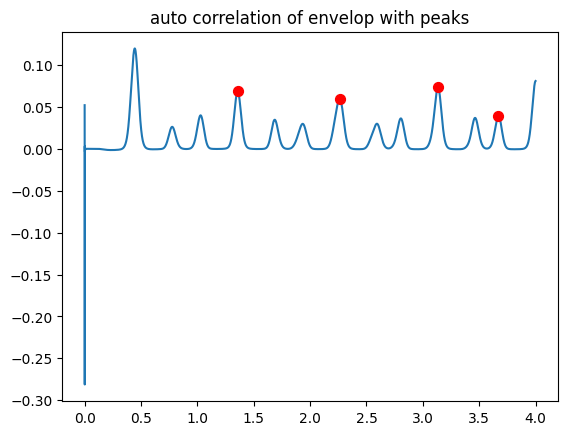

Passed criteria 1


[2.5382785135861944e-06, 0.0006550402243293411, 0.008037396398928488]
Passed criteria 2
Passed criteria 3


Passed criteria 1


[1.6970725659634933e-05, 0.00020383095473770454, 0.007203457211739917]
Passed criteria 2
Passed criteria 3


Passed criteria 1


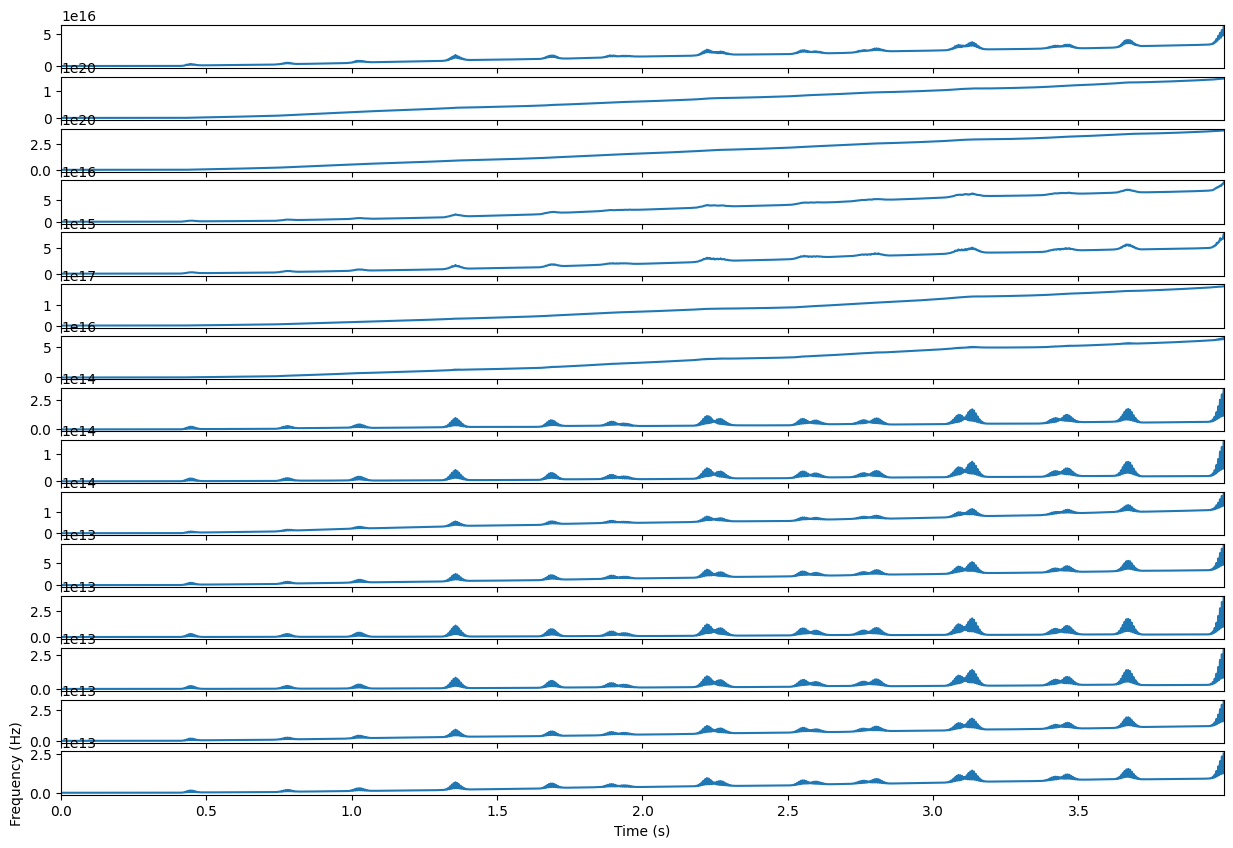

[5.6187425022902475e-05, 0.00021907145288176837, 0.008493647728918849]
Passed criteria 2
Passed criteria 3


Passed criteria 1


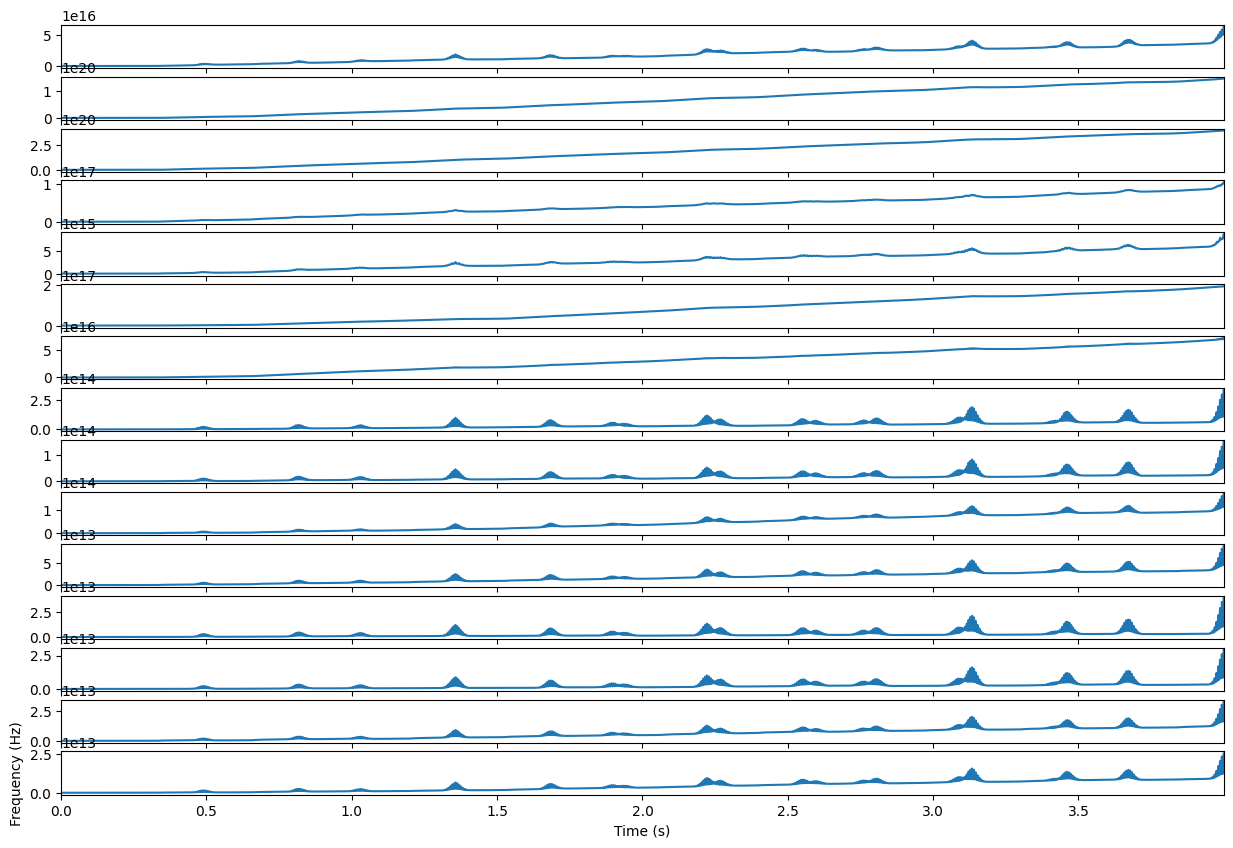

[4.2116126524216676e-05, 0.0007336532567900454, 0.008649173191234498]
Passed criteria 2
Passed criteria 3


Passed criteria 1


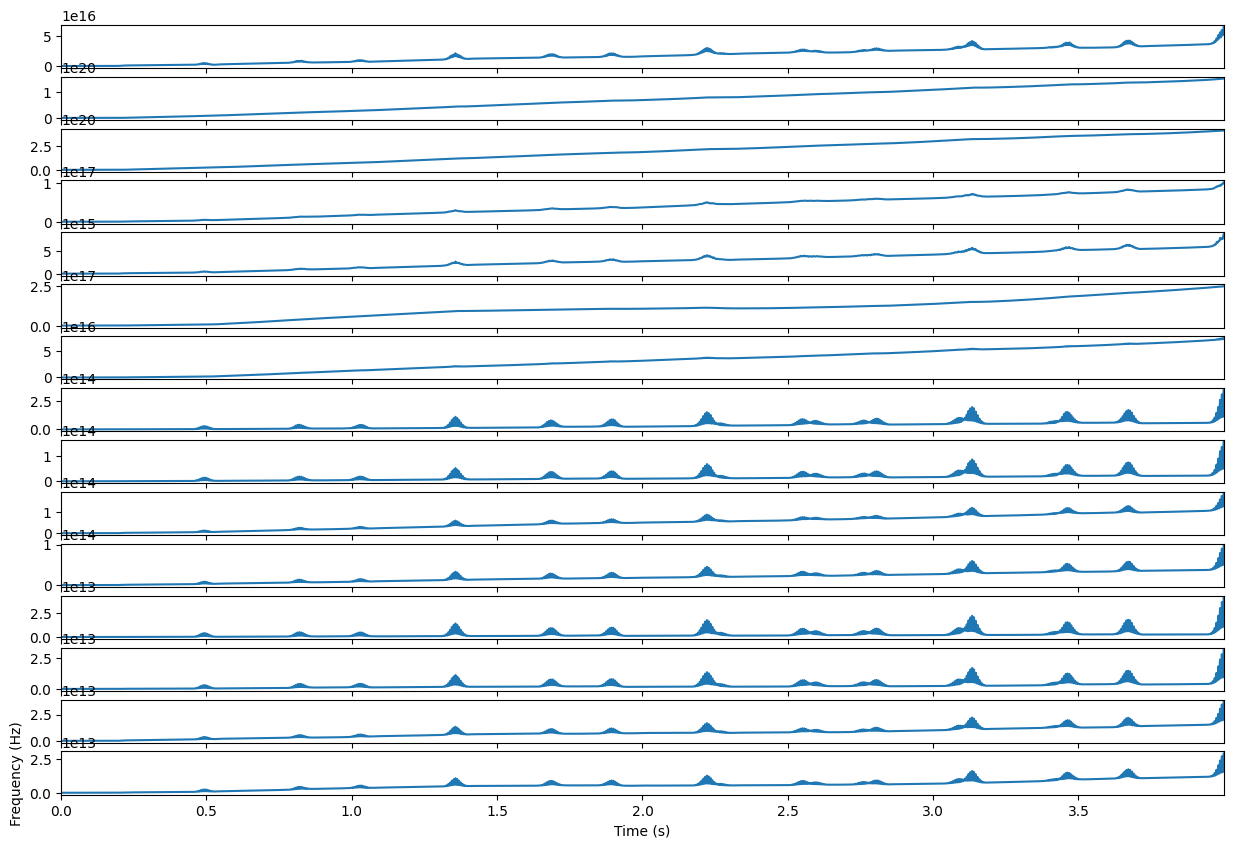

[4.432694171064155e-06, 0.0010887750399944003, 0.008414210018903261]
Passed criteria 2
Passed criteria 3


Passed criteria 1


[2.1284573378987588e-05, 0.0002467481456461791, 0.009479335298670271]
Passed criteria 2
Passed criteria 3


Passed criteria 1


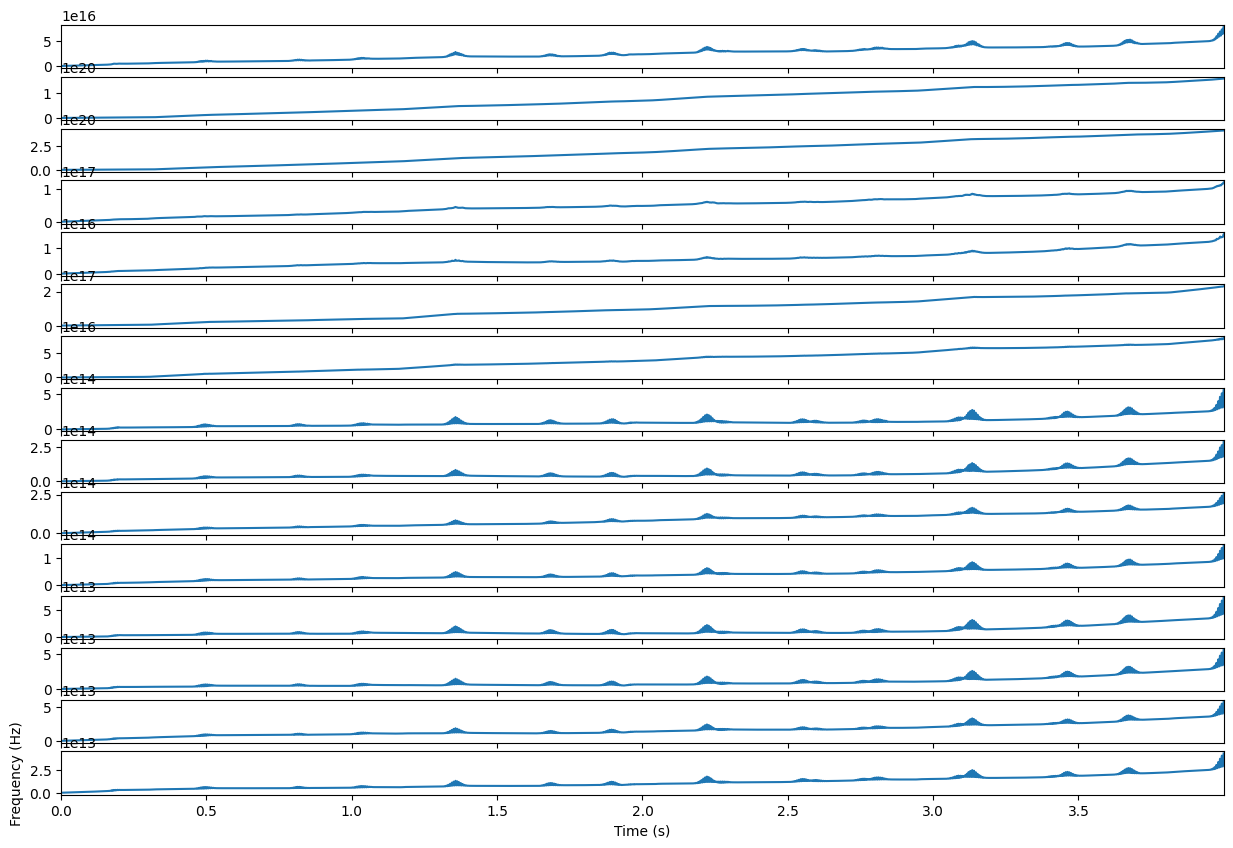

[1.5036638874497885e-05, 7.438597202615453e-05, 0.006052293171608335]
Passed criteria 2
Passed criteria 3


Passed criteria 1


[2.4770615097551982e-05, 0.0009878674317711053, 0.007646914358165755]
Passed criteria 2
Passed criteria 3


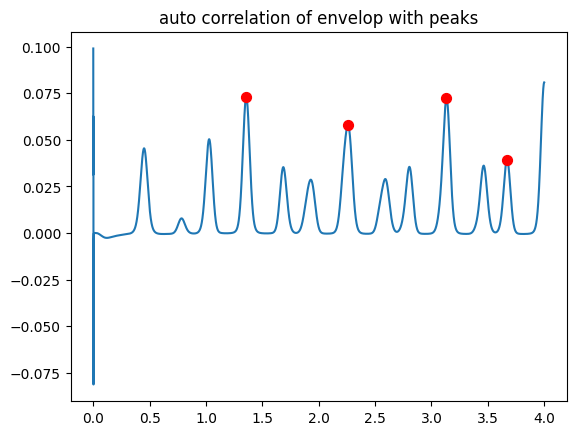

Passed criteria 1


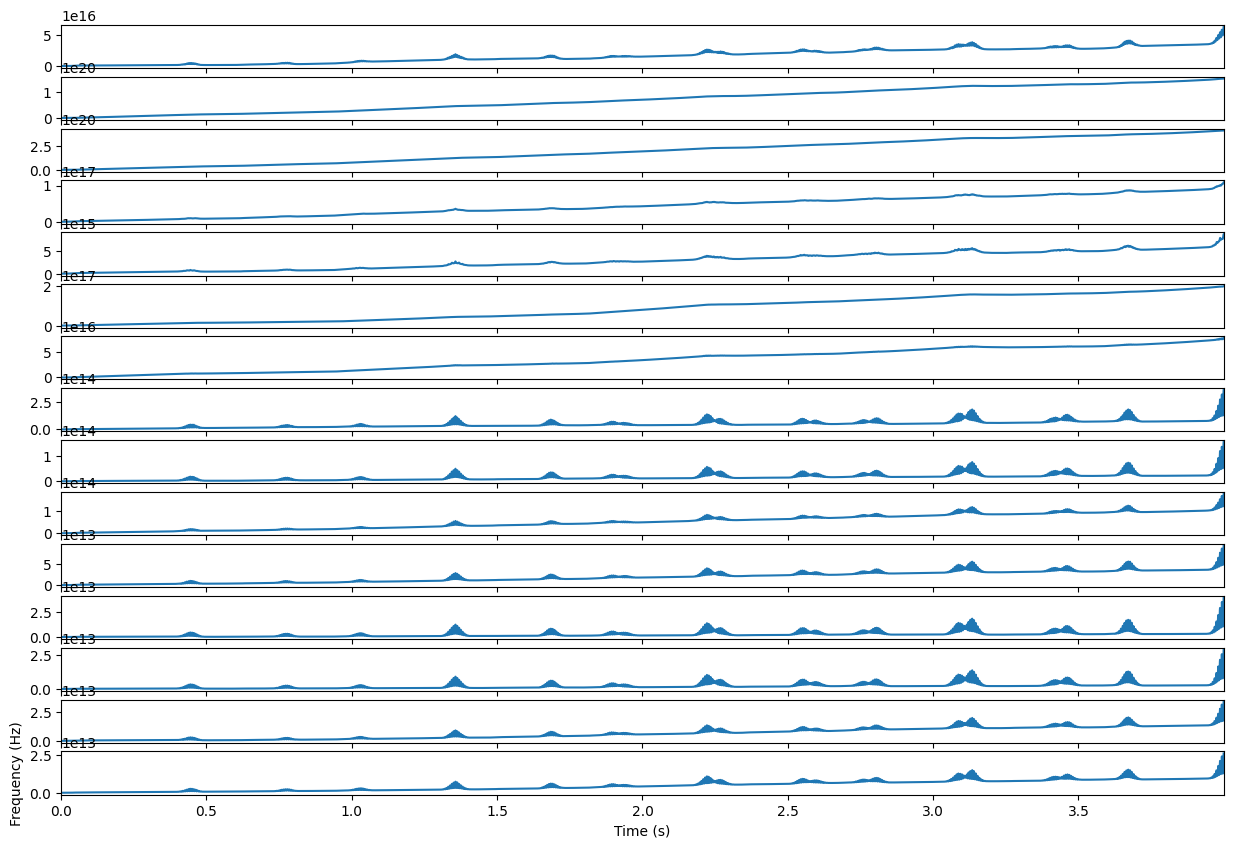

[3.888003556377443e-06, 0.0006712961767706082, 0.007585910146033508]
Passed criteria 2
Passed criteria 3


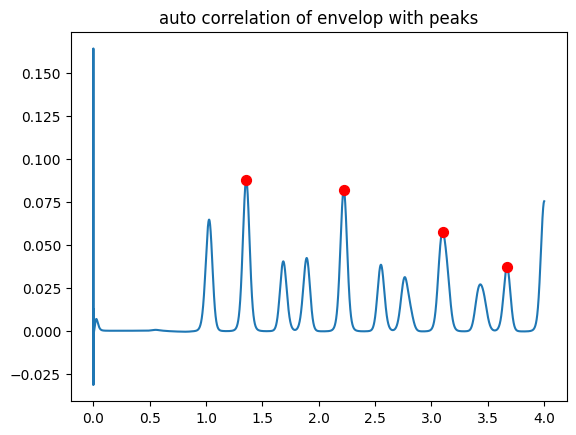

Passed criteria 1


[9.365565037436771e-07, 0.0009972382084876728, 0.00904377336098346]
Passed criteria 2
Passed criteria 3


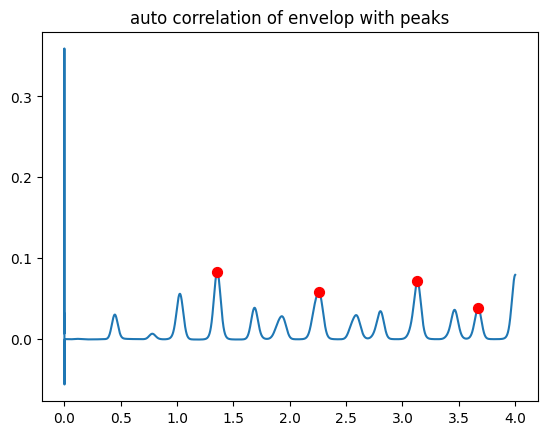

Passed criteria 1


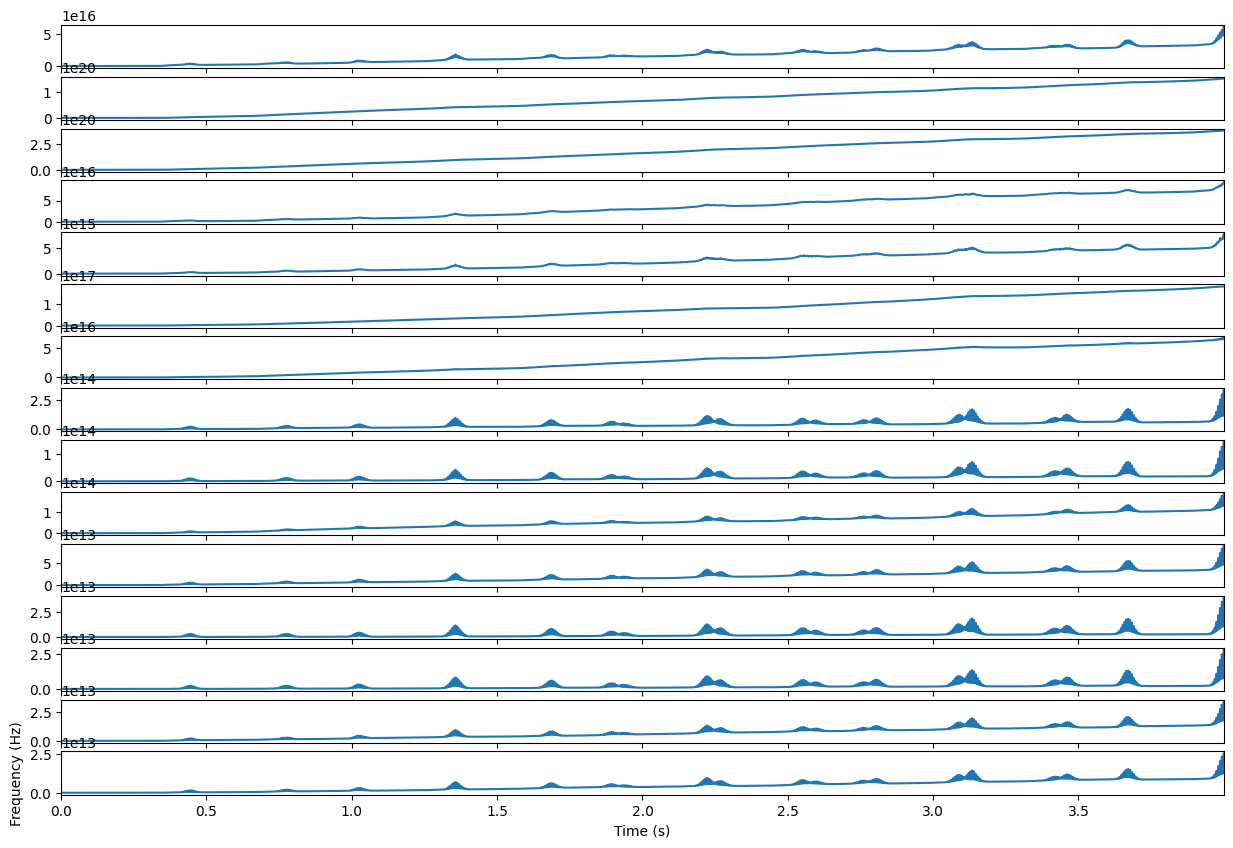

[4.6588988917572094e-05, 0.00021562069774687254, 0.008502371012221158]
Passed criteria 2
Passed criteria 3


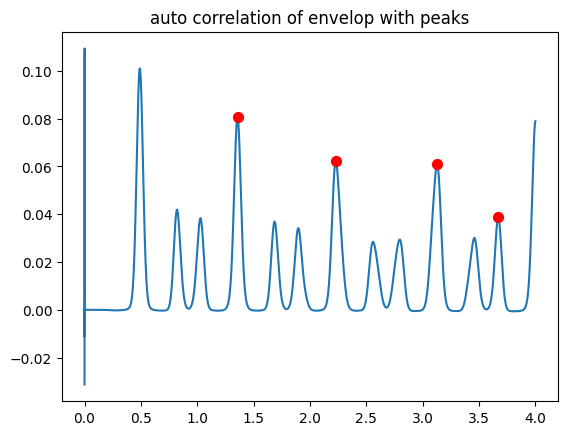

Passed criteria 1


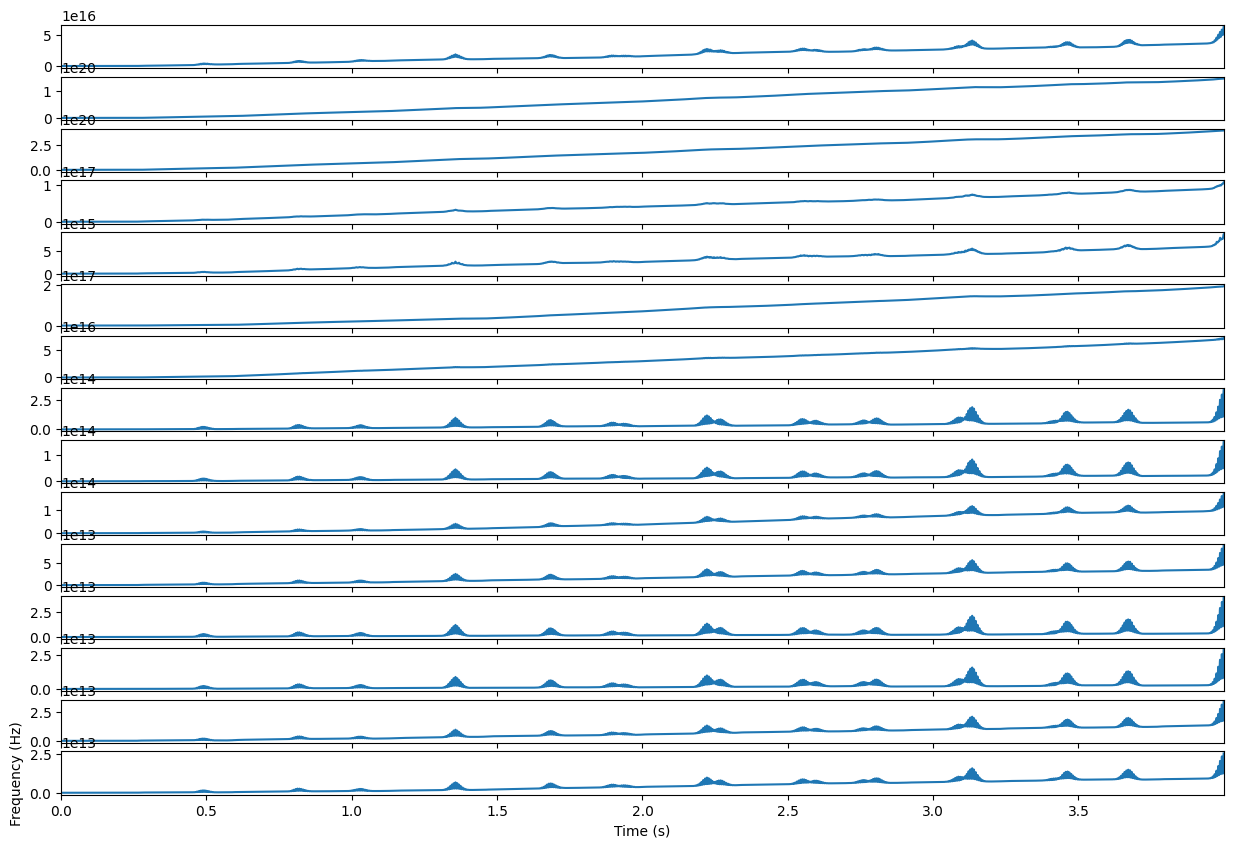

[4.54377707151607e-05, 0.0006532690231505952, 0.008166062378163787]
Passed criteria 2
Passed criteria 3


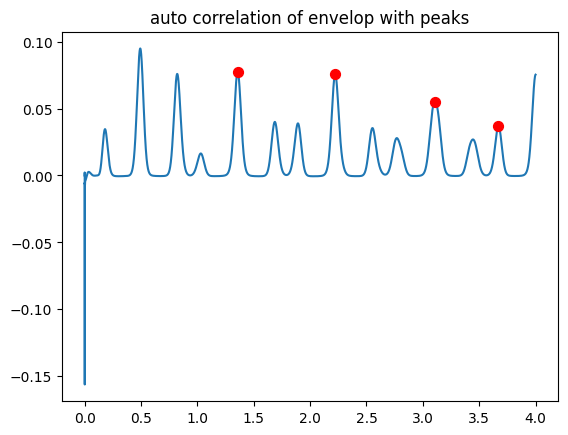

Passed criteria 1


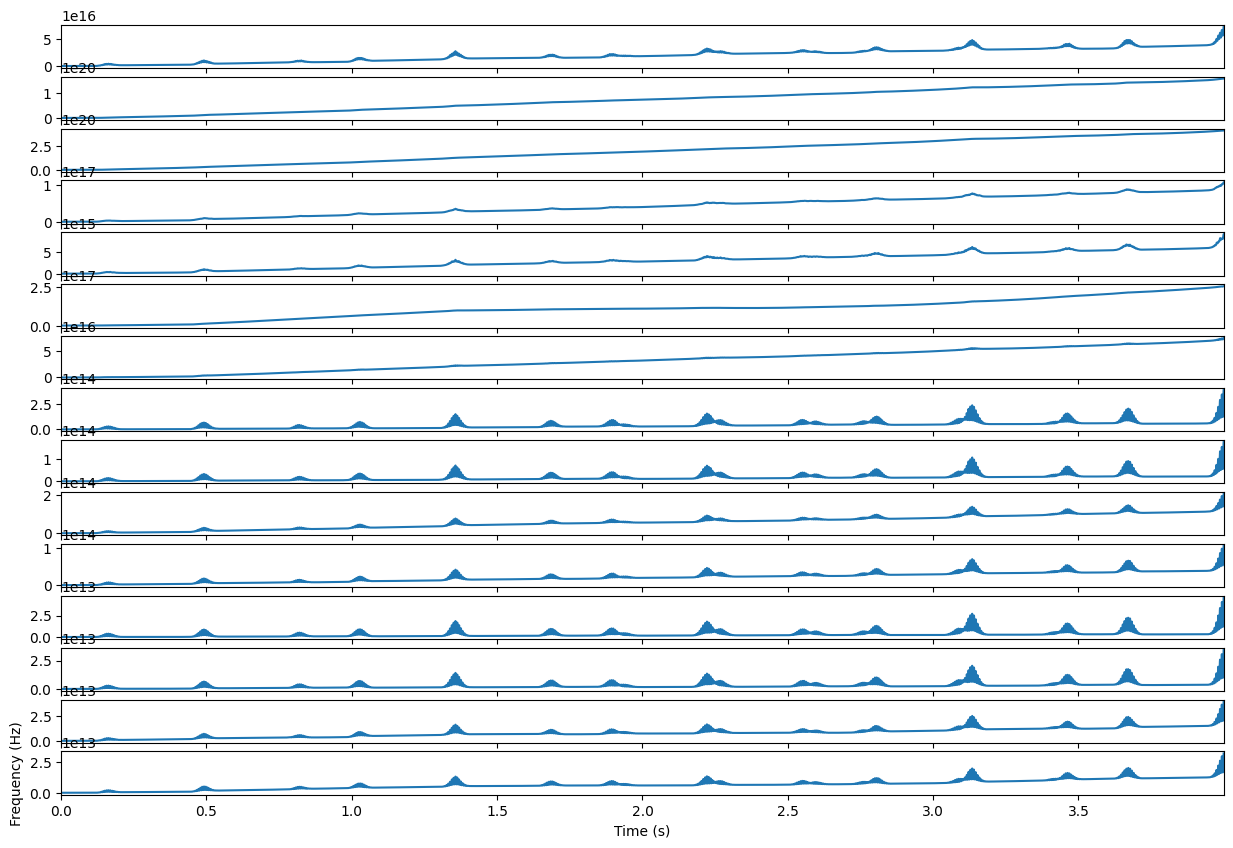

[7.020386077947798e-06, 0.0010810916743106756, 0.009597896850361316]
Passed criteria 2
Passed criteria 3


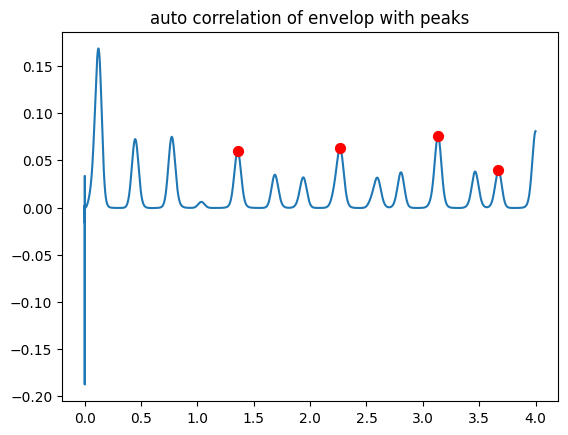

Passed criteria 1


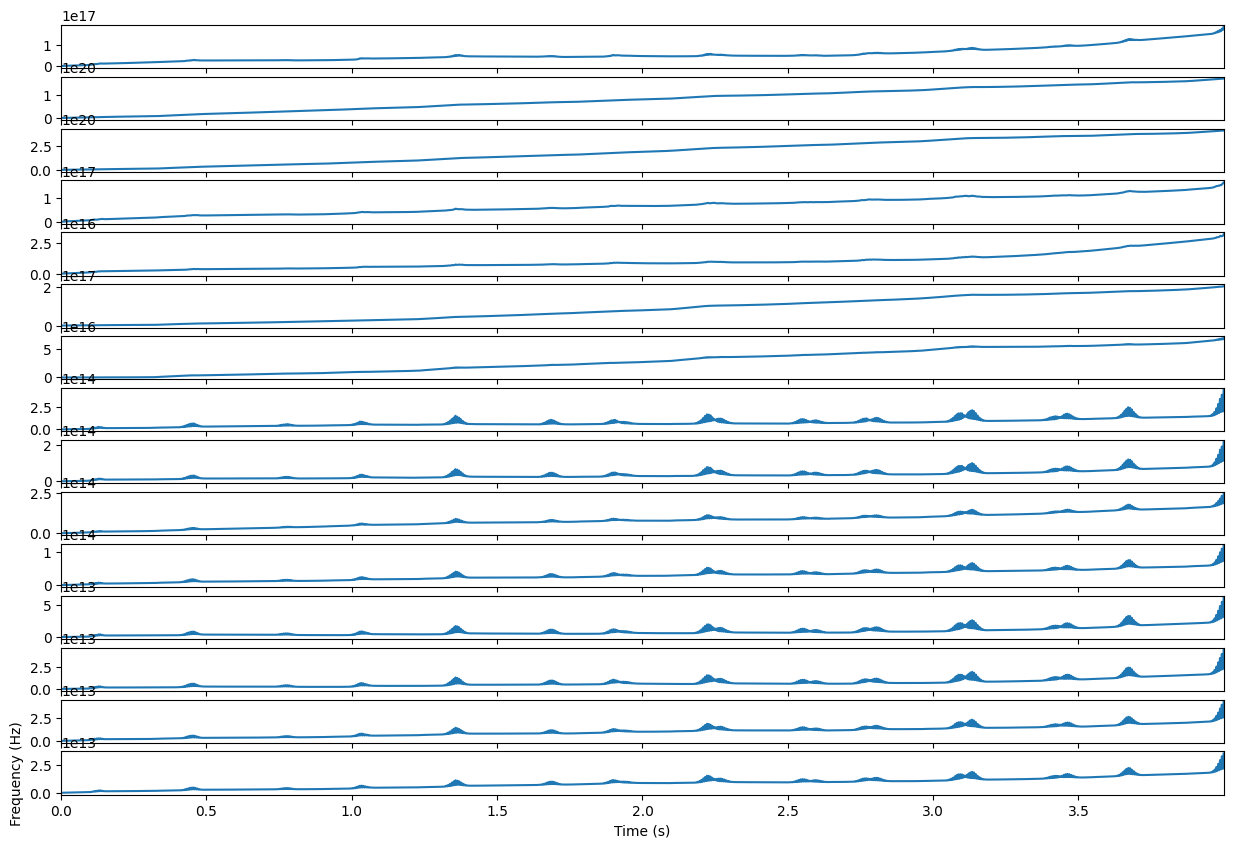

[0.00018372564739672218, 6.924230219259613e-05, 0.00443161955257897]
Failed criteria 2


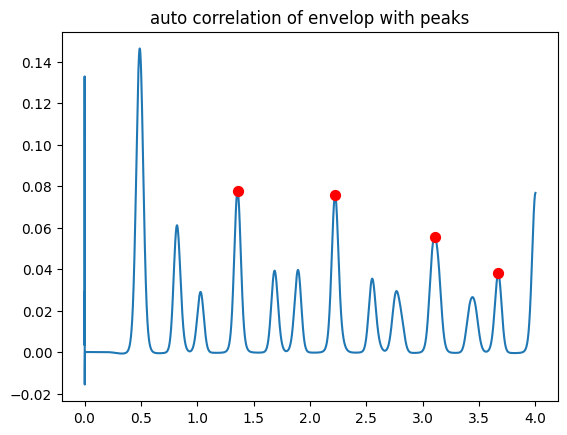

Passed criteria 1


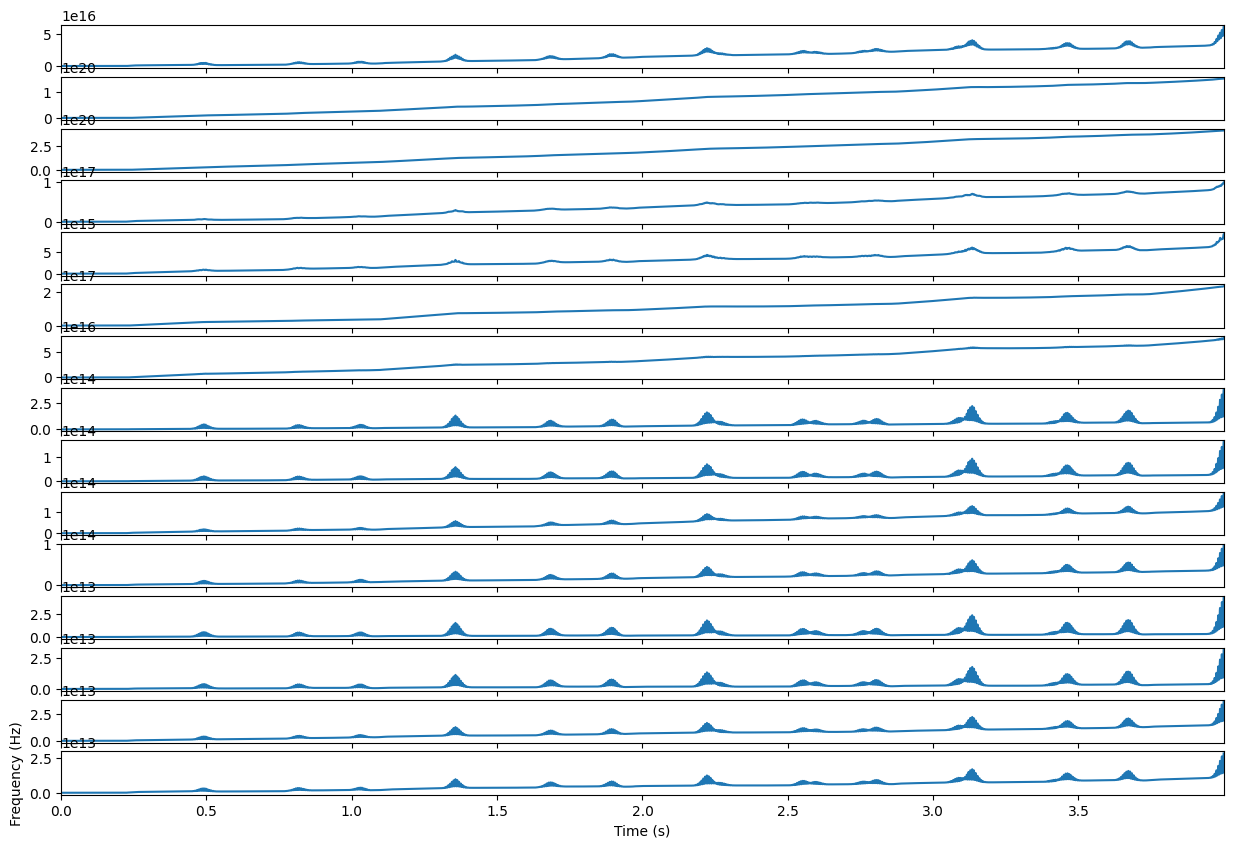

[3.466588313494918e-05, 9.23978537706421e-05, 0.009167052133990043]
Passed criteria 2
Passed criteria 3


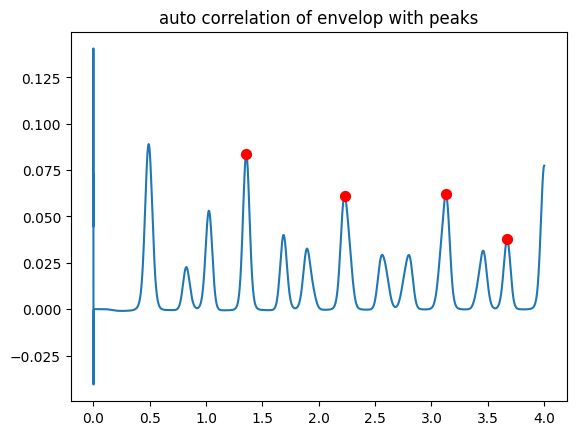

Passed criteria 1


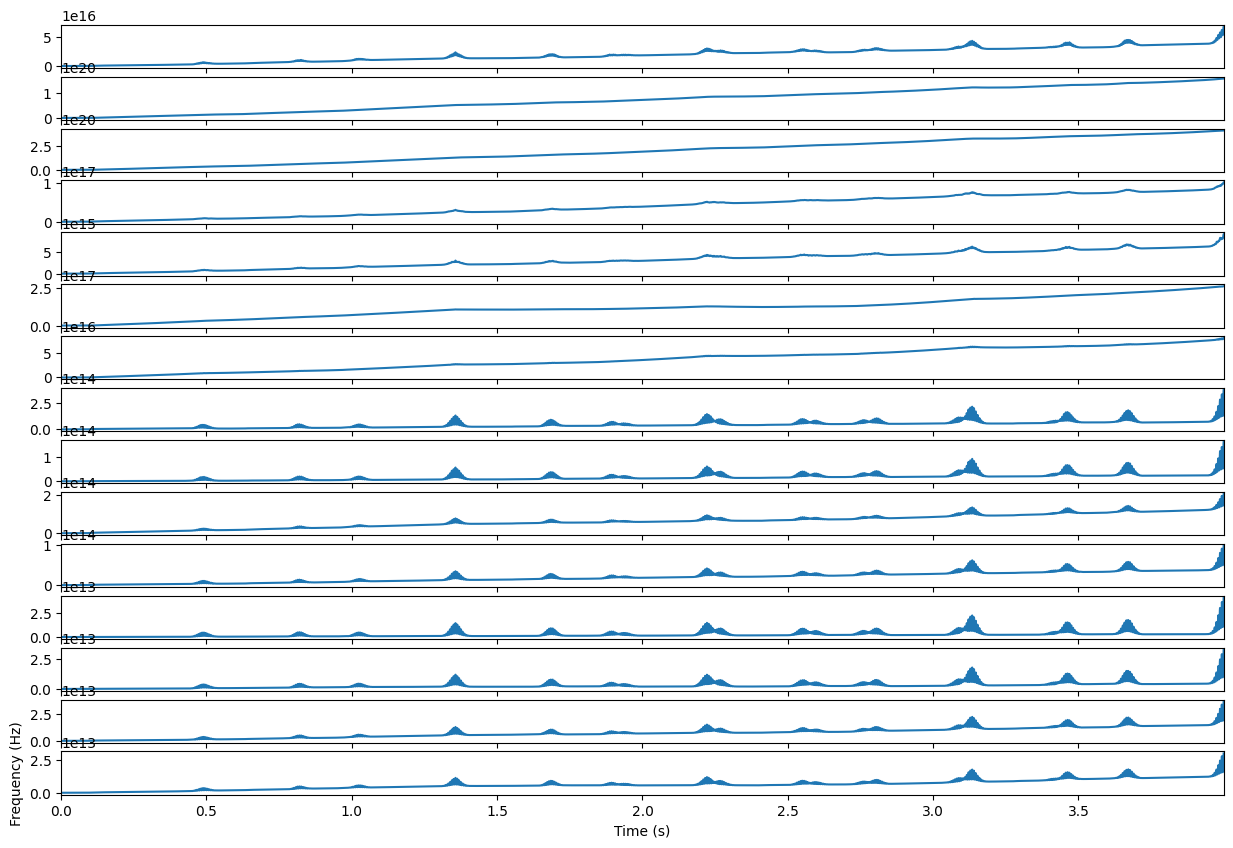

[2.7196640714792625e-05, 0.0009317579927189431, 0.007764954520594981]
Passed criteria 2
Passed criteria 3


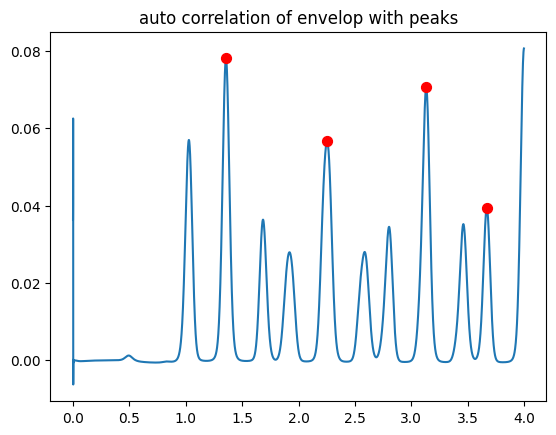

Passed criteria 1


[3.152794216495413e-05, 0.000887501406171689, 0.0037824531798956976]
Passed criteria 2
Passed criteria 3


Passed criteria 1


[1.7136595744675964e-06, 0.0010402923684994572, 0.008526303571752247]
Passed criteria 2
Passed criteria 3


Passed criteria 1


[3.868753966377211e-05, 0.000212109979773706, 0.00797167536208693]
Passed criteria 2
Passed criteria 3


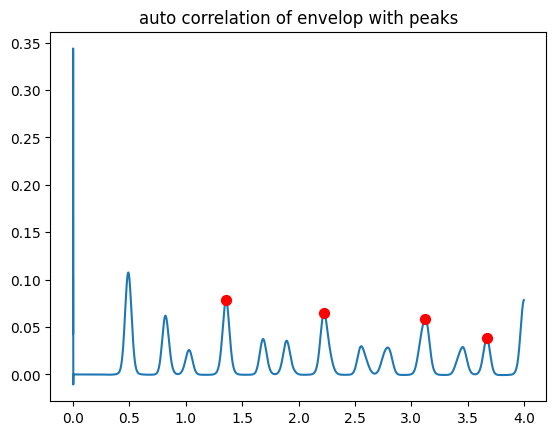

Passed criteria 1


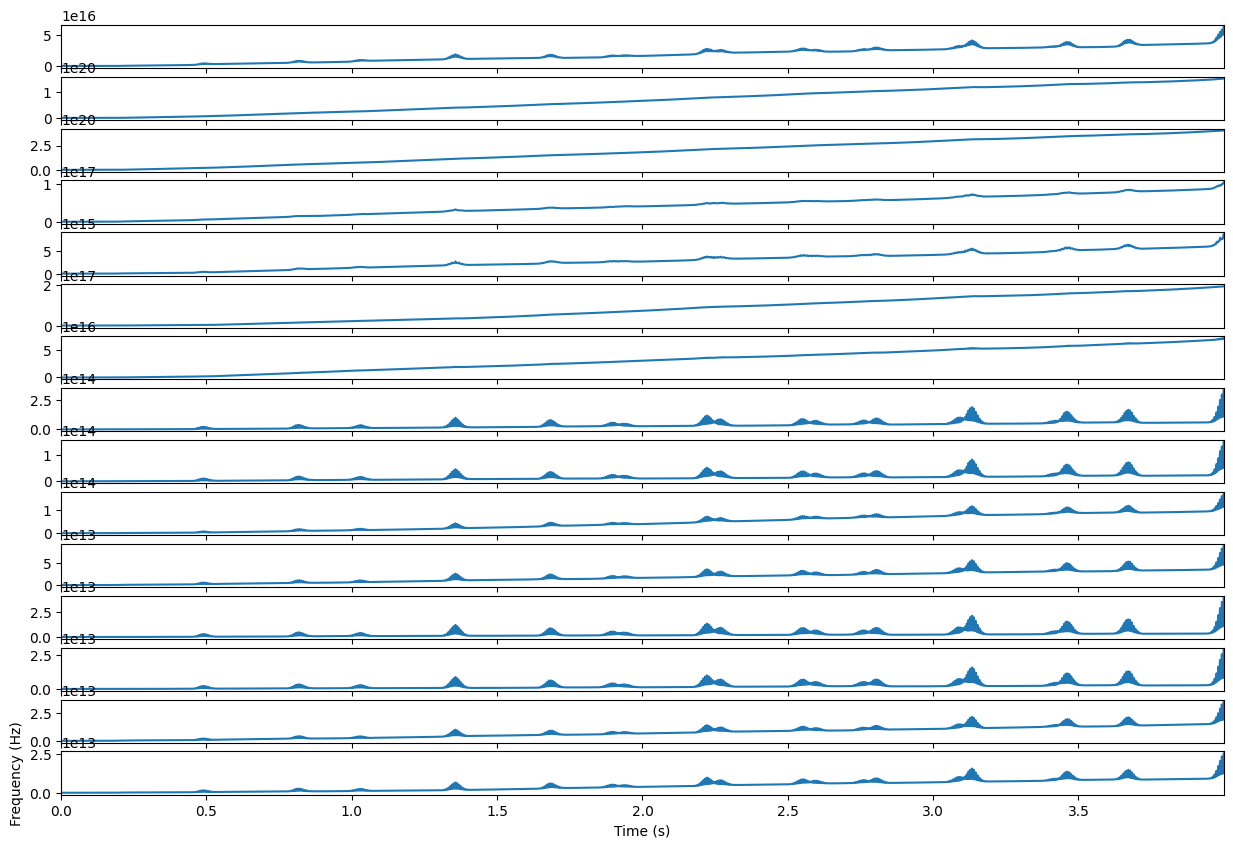

[4.5609162355041164e-05, 0.0006039274674721174, 0.007820680004926922]
Passed criteria 2
Passed criteria 3


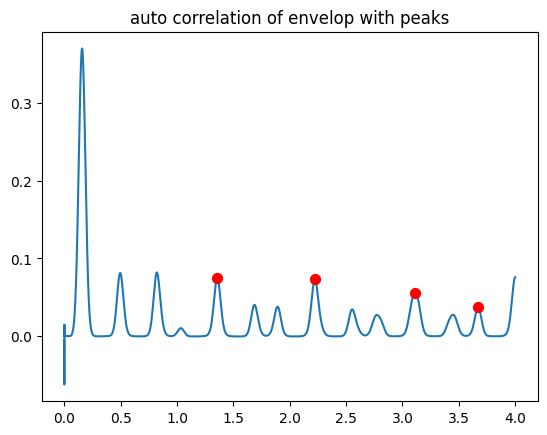

Passed criteria 1


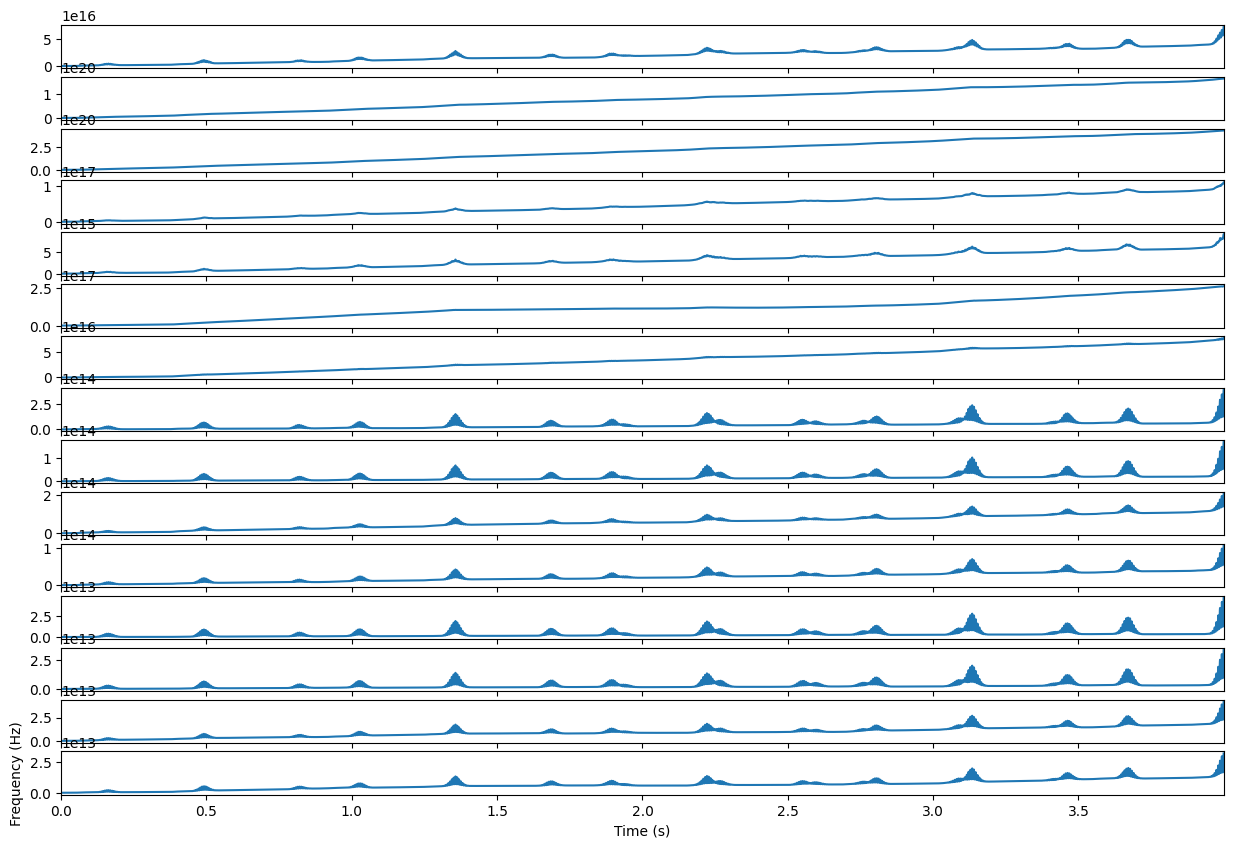

[1.0904159587426298e-05, 0.0010755736523940548, 0.009194675804038337]
Passed criteria 2
Passed criteria 3


In [1]:
import sys
import subprocess
import numpy as np
from matplotlib import pyplot as plt
from load_data import load_wav,pre_process
from noise_detect_phase_1 import noise_detection_phase_1
from hr_estimate import pre_find_hr

def plot_signal(data,title):
    plt.plot(np.linspace(0, len(data)/samplerate, len(data)), data)
    plt.title(title)
    plt.show()
    return
def down_sampling(data, samplerate, target_fre):
    factor = int(samplerate / target_fre)
    return int(samplerate / factor), data[::factor]



patient_id=sys.argv[1]
pos=sys.argv[2]
#data_path='./data/'+patient_id+'/'+patient_id+'_'+pos+'.wav'
data_path='./test_clean_pcg.wav'
samplerate, data = load_wav(data_path)
target_fre=2000
samplerate,data= down_sampling(data,samplerate,target_fre)
data= pre_process(data)
plot_signal(data,'Original Signal')

# estimate hear cycle first
est_hr=pre_find_hr(data,samplerate)


# start phase 1

start = 0
end = start+4
ref_seg=[]

while end <= len(data)/samplerate:
    result=noise_detection_phase_1(patient_id,pos,start,end,est_hr)
    if result is not False:
        ref_seg.append(result)
    start=start+1
    end=end+1

ref=ref_seg[0]


In [31]:
import numpy as np
from scipy.signal import ShortTimeFFT

# spectral energy
def stft_win(signal,fs):
    N=len(signal)
    win=np.hanning(N)
    for i in range(N):
        if i > N/2:
            win[i]=0
    SFT=ShortTimeFFT(win=win,fs=fs,hop=1)
    STFT=np.abs(SFT.stft(signal))
    return STFT
def root_mean_square(stft):
    s_rms=np.zeros(stft.shape[0])
    for i in range(stft.shape[0]):
        s_rms[i]=np.sqrt(np.sum(stft[i]**2))
    return s_rms
def srms_evaluate(ref,test,fs):
    ref_stft=stft_win(ref,fs)
    test_stft=stft_win(test,fs)
    ref_rms=root_mean_square(ref_stft)
    test_rms=root_mean_square(test_stft)
    coef=np.corrcoef(ref_rms,test_rms)[0][1]
    if coef>0.98:
        print("Segment passed spectral RMS test")
        return True
    else:
        print("Segment failed spectral RMS test, correlation coefficient:",coef)
        return False
# temporal energy
def ref_max_te(ref,fs):
    tw=int(0.05*fs)
    max_te=0
    for i in range(0,len(ref),int(tw)):
        te=np.sum([x**2 for x in ref[i:i+tw]])
        if te>max_te:
            max_te=te
    return max_te
def test_rte(test,fs,ref_te):
    tw=int(0.05*fs)
    rte=np.zeros(int(len(test)//tw))
    for i in range(0,rte.shape[0]):
        rte[i]=np.sum([x**2 for x in test[i*tw:i*tw+tw]])/ref_te
    return rte
def te_evaluate(rte):
    for r in rte:
        if r>3:
            print("failed temporal energy test with relative temporal energy ",r)
            return False
    print("passed temporal energy test")
    return True


In [32]:
ref_te=ref_max_te(ref, samplerate)
for i in range(0,len(data)-len(ref),int(0.5*samplerate)):
    test=data[i:int(i+len(ref))]
    # first criteria
    srms_evaluate(ref,test,samplerate)
    # second criteria
    rte=test_rte(test,samplerate,ref_te)
    te_evaluate(rte)

Segment passed spectral RMS test
passed temporal energy test
Segment passed spectral RMS test
passed temporal energy test
Segment passed spectral RMS test
passed temporal energy test
Segment passed spectral RMS test
passed temporal energy test
Segment passed spectral RMS test
passed temporal energy test


KeyboardInterrupt: 